In [1]:
from gw_signal_tools.waveform_utils import (
    td_to_fd_waveform, fd_to_td_waveform,
    pad_to_get_target_df, restrict_f_range,
    get_strain
)

from gw_signal_tools.inner_product import (
    inner_product, norm, overlap
)

from gw_signal_tools.PSDs import psd_gw150914

import astropy.units as u
import lalsimulation.gwsignal.core.waveform as wfm
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', '.*This code is currently UNREVIEWED, use with caution!.*')

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


In [2]:
from gw_signal_tools import PLOT_STYLE_SHEET
plt.style.use(PLOT_STYLE_SHEET)

In [3]:
# Define the dictionary
f_min = 20.*u.Hz

parameters_gw150914 = {
    'mass1' : 36*u.solMass,
    'mass2' : 29*u.solMass,
    'deltaT' : 1./2048.*u.s,
    'f22_start' : f_min,  # Lower cutoff frequency
    'f22_ref': 20.*u.Hz,# Frequency where spins are specified
    'phi_ref' : 0.*u.rad,
    'distance' : 1.*u.Mpc,
    'inclination' : 0.0*u.rad,
    'eccentricity' : 0.*u.dimensionless_unscaled,
    'longAscNodes' : 0.*u.rad,
    'meanPerAno' : 0.*u.rad,
    'condition' : 0
}

# Define the approximant
approximant = 'IMRPhenomXPHM'

# Call the generator
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)


# Generate time domain waveform
hp_t, hc_t = wfm.GenerateTDWaveform(parameters_gw150914, gen)


# Two waveforms will be generated in frequency domain, first with finer
# sampling and then with coarser one
hp_f_fine, hc_f_fine = wfm.GenerateFDWaveform(parameters_gw150914, gen)
hp_f_fine.override_unit(u.s)
hc_f_fine.override_unit(u.s)

hp_f_coarse, hc_f_coarse = wfm.GenerateFDWaveform(parameters_gw150914 | {'deltaF': 1.0 / (hp_t.size * hp_t.dx)}, gen)
hp_f_coarse.override_unit(u.s)
hc_f_coarse.override_unit(u.s)

### Testing restrict_f_range speed

In [4]:
%%timeit -n 10 -r 10

f_lower_crop = 42.0 * u.Hz

hp_f_fine, _ = wfm.GenerateFDWaveform(parameters_gw150914, gen)
# hp_f_fine.crop(start=f_lower_crop)
df = hp_f_fine.df

number_to_fill = int(f_lower_crop / df)
hp_f_fine[:number_to_fill] = np.zeros(number_to_fill)

177 ms ± 12.9 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [5]:
%%timeit -n 10 -r 10

f_lower_crop = 42.0 * u.Hz

hp_f_fine, _ = wfm.GenerateFDWaveform(parameters_gw150914, gen)
# hp_f_fine.crop(start=f_lower_crop)

hp_f_fine = restrict_f_range(hp_f_fine, f_range=[f_lower_crop, None], copy=True)
# hp_f_fine = restrict_f_range(hp_f_fine, f_range=[f_lower_crop, None], copy=False)

189 ms ± 12.9 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


copy=True: around 190 with .fill, around 190 with newer one (ones and multiply with fill_val)

copy=False: around 180 with .fill, around 180 with newer one (ones and multiply with fill_val)

Now verifying that no inplace editing takes place

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


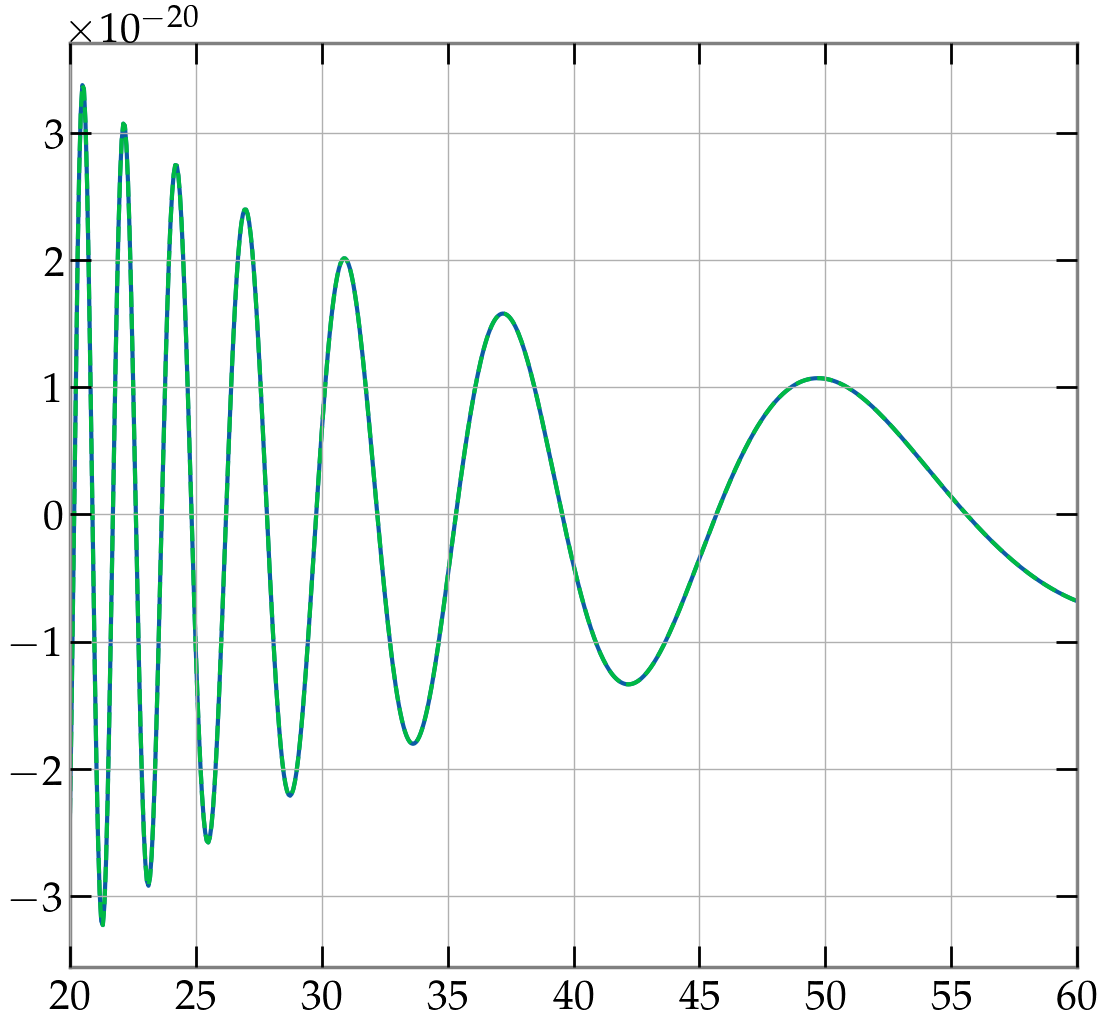

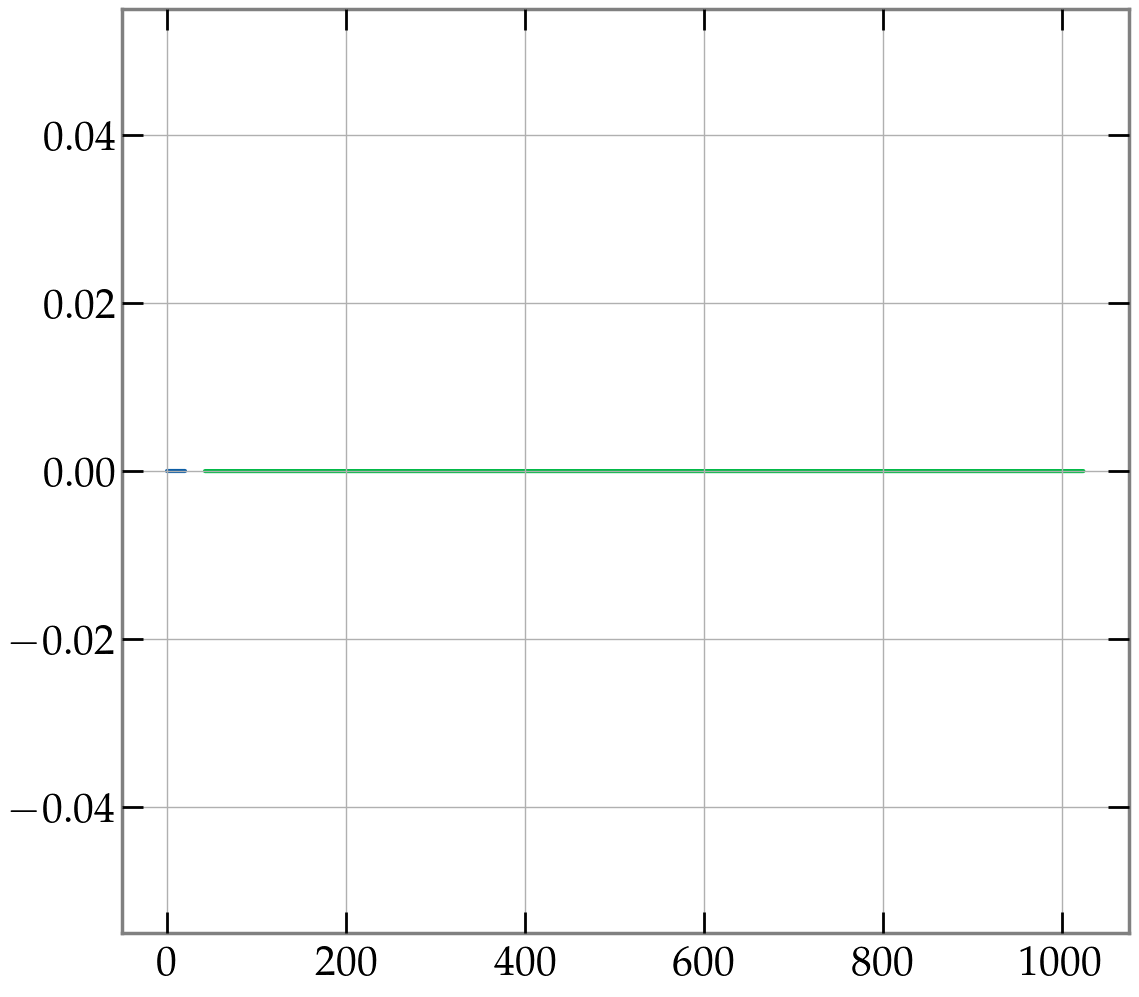

In [6]:
f_lower_crop = 42.0 * u.Hz

hp_f_fine, _ = wfm.GenerateFDWaveform(parameters_gw150914, gen)


plt.plot(hp_f_fine)

hp_f_fine_2 = restrict_f_range(hp_f_fine, f_range=[f_lower_crop, None], copy=True)
# hp_f_fine_2 = restrict_f_range(hp_f_fine, f_range=[f_lower_crop, None], copy=False)


plt.plot(hp_f_fine, '--')


plt.xlim([20, 60])

plt.show()


plt.plot((hp_f_fine - hp_f_fine_2).crop(end=f_min))
# In between, we make second one zero, but first one is not zero.
# Thus excluded in this plot, we want to see if everything is zero
plt.plot((hp_f_fine - hp_f_fine_2).crop(start=f_lower_crop))

plt.show()

Testing if pad_to_f_zero works as intended, i.e. if it copies

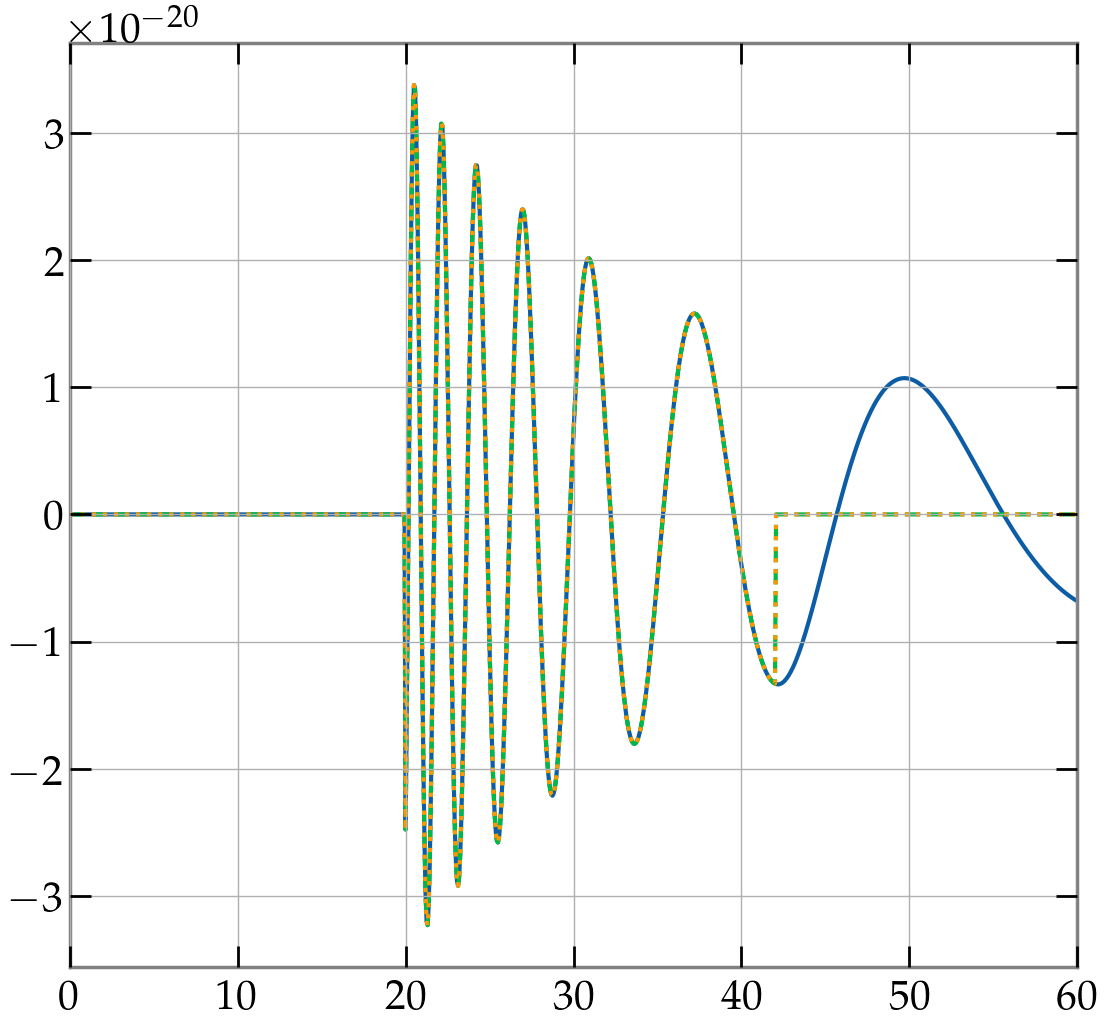

In [7]:
f_upper_crop = 42.0 * u.Hz

hp_f_fine, _ = wfm.GenerateFDWaveform(parameters_gw150914, gen)


plt.plot(hp_f_fine)


hp_f_fine_2 = restrict_f_range(hp_f_fine, f_range=[None, f_upper_crop], pad_to_f_zero=True, copy=False)


plt.plot(hp_f_fine, '--')
plt.plot(hp_f_fine_2, ':')


plt.xlim([0, 60])

plt.show()

## Inner Product

In [8]:
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

from gwpy.timeseries.timeseries import TimeSeries
from gwpy.frequencyseries.frequencyseries import FrequencySeries

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [9]:
f_low, f_high = 20, 350

sample_rate = 4096


# Enter some arbitrary parameters here
signals_to_compare = {
    'signal1': {
        'mass1': 10,
        'mass2': 10,
        'spin1': 0.6,
        'spin2': 0.0
    },
    'signal2':{
        'mass1': 96,
        'mass2': 20,
        'spin1': 0.0,
        'spin2': 0.1
    }
}


hp_1_pycbc, _ = get_fd_waveform(
    approximant=approximant,
    **signals_to_compare['signal1'],
    f_lower=f_low,
    f_upper=f_high,
    delta_f=1.0/sample_rate
)

hp_2_pycbc, _ = get_fd_waveform(
    approximant=approximant,
    **signals_to_compare['signal2'],
    f_lower=f_low,
    f_upper=f_high,
    delta_f=1.0/sample_rate
)

tlen = max(len(hp_1_pycbc), len(hp_2_pycbc))
hp_1_pycbc.resize(tlen)
hp_2_pycbc.resize(tlen)

delta_f = 1.0 / hp_2_pycbc.duration
flen = tlen//2 + 1
psd_pycbc = aLIGOZeroDetHighPower(flen, delta_f, f_low)


hp_1_pycbc_converted = FrequencySeries.from_pycbc(hp_1_pycbc) * u.s
hp_2_pycbc_converted = FrequencySeries.from_pycbc(hp_2_pycbc) * u.s
psd_pycbc_converted = FrequencySeries.from_pycbc(psd_pycbc) / u.Hz

Testing which method is most efficient

In [10]:
# Set test parameters
df_test = None
# df_test = 2**-6*u.Hz
# f_range_test = None
f_range_test = [None, 1023.875*u.Hz]
optimize = True
# optimize = False

In [11]:
_ = match(hp_1_pycbc, hp_2_pycbc, psd=psd_pycbc, low_frequency_cutoff=f_low, high_frequency_cutoff=f_high)  # Initialize match function (not sure if it works)

%timeit match(hp_1_pycbc, hp_2_pycbc, psd=psd_pycbc, low_frequency_cutoff=f_low, high_frequency_cutoff=f_high)

2.51 s ± 111 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Hm, this can't be right. There is probably some initilization going on for each call

In [12]:
%timeit -n 100 -r 10 norm(hp_t, psd_gw150914, df=df_test, f_range=f_range_test, optimize_time_and_phase=True)

19.3 ms ± 603 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [13]:
%timeit -n 100 -r 10 norm(hp_t, psd_gw150914, df=0.125, f_range=f_range_test, optimize_time_and_phase=True)

13.5 ms ± 605 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [14]:
%timeit -n 100 -r 10 norm(hp_f_fine, psd_gw150914, df=df_test, f_range=f_range_test, optimize_time_and_phase=True)

15 ms ± 463 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [15]:
%timeit -n 100 -r 10 norm(hp_f_coarse, psd_gw150914, df=df_test, f_range=f_range_test, optimize_time_and_phase=True)

16.1 ms ± 634 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


Clearly, choice of df makes bigger difference for time domain waveform, as opposed to frequency domain one. -> I think this changed; for df=None there is no need for resampling, which is because of correct input df

However, one should remember that generating with finer resolution also takes more time. So let us now see which method is fastest overall

In [16]:
print(gen.metadata['implemented_domain'], gen.metadata['generation_domain'])

freq freq


Thus, in theory, frequency domain should be much faster (since model is implemented there and inner product computation is also faster there)

In [17]:
%%timeit -n 10 -r 10

hp_t, _ = wfm.GenerateTDWaveform(parameters_gw150914, gen)

norm(hp_t, psd_gw150914, df=df_test, f_range=f_range_test)

168 ms ± 11.1 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [18]:
%%timeit -n 10 -r 10

hp_t, _ = wfm.GenerateTDWaveform(parameters_gw150914, gen)

norm(hp_t, psd_gw150914, df=0.125, f_range=f_range_test)

168 ms ± 7.37 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [19]:
%%timeit -n 10 -r 10

hp_f_fine, _ = wfm.GenerateFDWaveform(parameters_gw150914, gen)

norm(hp_f_fine, psd_gw150914, df=df_test, f_range=f_range_test)

187 ms ± 7.87 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [20]:
%%timeit -n 10 -r 10

hp_f_coarse, _ = wfm.GenerateFDWaveform(parameters_gw150914 | {'deltaF': 1.0 / (hp_t.size * hp_t.dx)}, gen)

norm(hp_f_coarse, psd_gw150914, df=df_test, f_range=f_range_test)

169 ms ± 6.72 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


The speeds are very similar for all of them. Naturally, finer sampling takes longer compared to coarser one, but apart from that the differences are almost non-existent

## Breakdown

In [21]:
import cProfile

In [22]:
cProfile.run(
    'norm(hp_t, psd_gw150914, optimize_time_and_phase=True)',
    sort=1
)

         40365 function calls (40198 primitive calls) in 0.098 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.010    0.003    0.010    0.003 {built-in method numpy.fft._pocketfft_internal.execute}
       82    0.009    0.000    0.009    0.000 {function Quantity.__array_ufunc__ at 0x7f993e7f8b80}
        2    0.005    0.002    0.018    0.009 core.py:1422(filter_units)
    11165    0.003    0.000    0.003    0.000 {built-in method builtins.isinstance}
     1594    0.003    0.000    0.005    0.000 {built-in method builtins.getattr}
      367    0.003    0.000    0.009    0.000 base.py:89(to_string)
      205    0.002    0.000    0.012    0.000 core.py:1126(_to)
       99    0.002    0.000    0.008    0.000 core.py:2381(_expand_and_gather)
      504    0.002    0.000    0.004    0.000 quantity.py:573(__array_finalize__)
       82    0.001    0.000    0.020    0.000 quantity.py:612(__array_ufunc__)
      136    0

In [23]:
cProfile.run(
    'norm(hp_f_fine, psd_gw150914, optimize_time_and_phase=True)',
    sort=1
)

         33948 function calls (33852 primitive calls) in 0.039 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.005    0.005    0.005    0.005 {built-in method numpy.fft._pocketfft_internal.execute}
        2    0.003    0.001    0.009    0.004 core.py:1422(filter_units)
       56    0.002    0.000    0.002    0.000 {function Quantity.__array_ufunc__ at 0x7f993e7f8b80}
    10538    0.001    0.000    0.001    0.000 {built-in method builtins.isinstance}
      331    0.001    0.000    0.003    0.000 base.py:89(to_string)
     1086    0.001    0.000    0.002    0.000 {built-in method builtins.getattr}
      157    0.001    0.000    0.004    0.000 core.py:1126(_to)
      332    0.001    0.000    0.001    0.000 quantity.py:573(__array_finalize__)
       76    0.001    0.000    0.002    0.000 core.py:2381(_expand_and_gather)
      210    0.001    0.000    0.001    0.000 {built-in method numpy.array}
       56    0.00

Ok, this is crazy... The EPOCH CONVERSION when calling restrict_f_range (which happened TWO (!) times) was the bottleneck that slowed us down??? And setting epoch=None for FrequencySeries is saving us???